In [ ]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

Image shape: (700, 1024, 3)


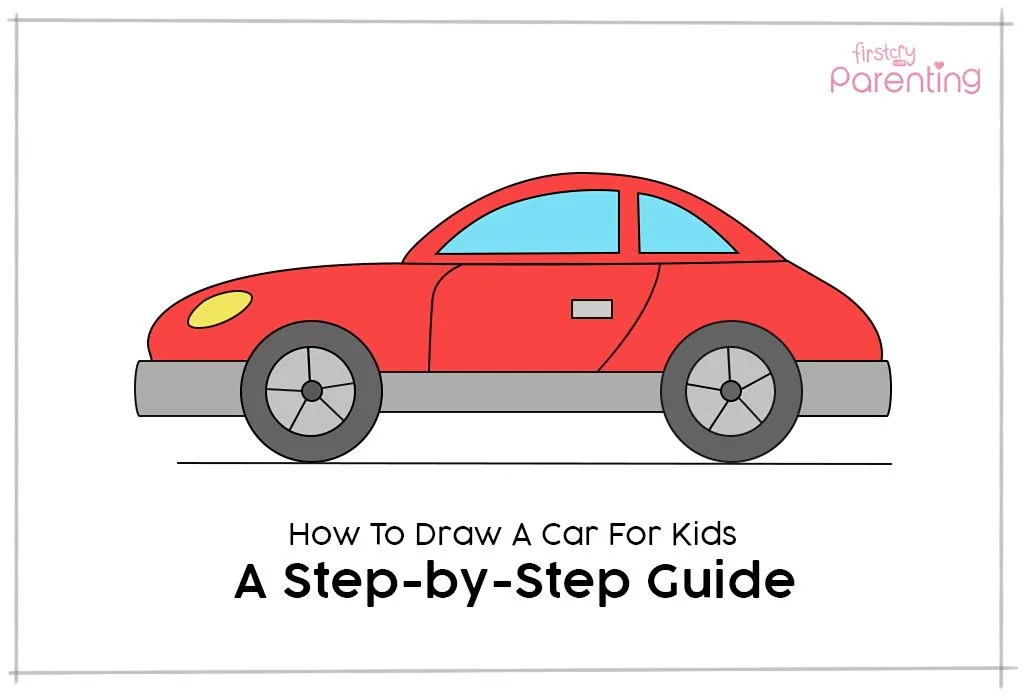

In [ ]:
img= cv2.imread('8.jpg')
print(f"Image shape:",img.shape)
cv2_imshow(img)

This image can be found at [red car image](https://parenting.firstcry.com/articles/how-to-draw-a-car-for-kids/?ref=interlink)

(700, 1024, 3)


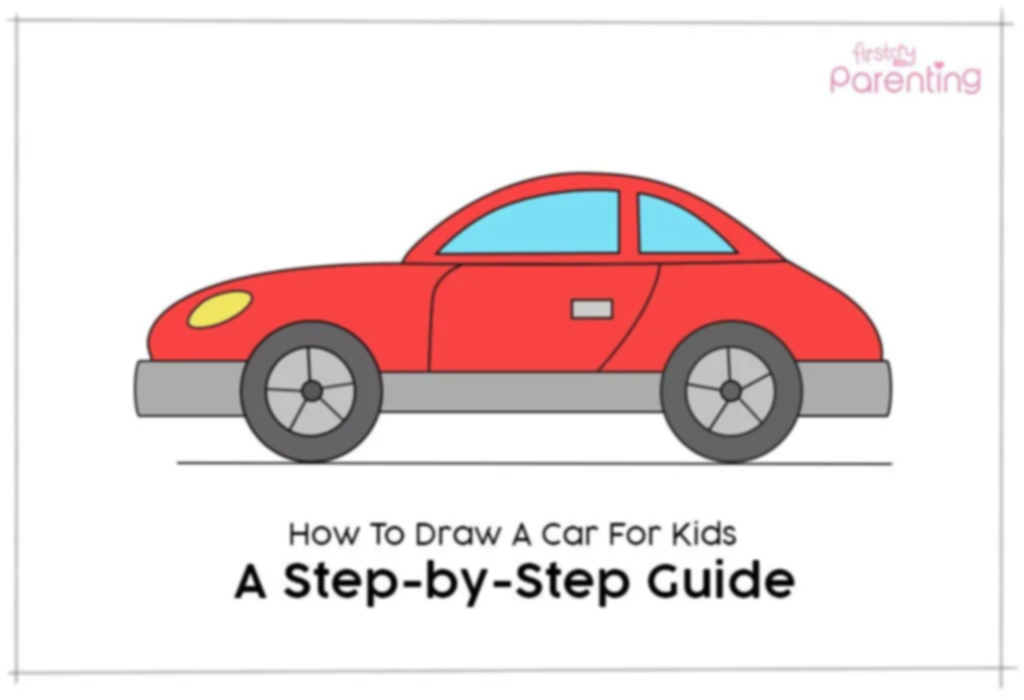

In [ ]:
blur_img = cv2.GaussianBlur(img,(7,7),0)
print(blur_img.shape)
cv2_imshow(blur_img)

# Assignment 1.1  

*   Implement the Gaussian blur filter from scratch





Resources of code [Wikipedia_Gaussian_blur](https://en.wikipedia.org/wiki/Gaussian_blur) & [University of Wisconsin](https://pages.stat.wisc.edu/~mchung/teaching/MIA/reading/diffusion.gaussian.kernel.pdf.pdf) & [OpenCV GaussianBlur](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1)

Here's the google style i followed here in writing comments [Google Style](https://developers.google.com/style/api-reference-comments)

In [ ]:

def gaussianKernel(ksize,sigma = 0):

    """
    Generating Gaussian Blur kernel.

      Args:
          ksize: A numpy array representing the kernel dimensions.
          sigma: A float value representing standard deviation.

      Returns:
          A numpy array representing the kernel.

      Time Complexity:
          O(f(Kx*Ky)), where Kx, Ky are the dimentions of the kernel.
    """

    # If sigma is not provided or is less than or equal to 0, calculate a default value based on ksize
    if sigma <= 0:
       sigma = 0.3 * ( (ksize[0] - 1)*0.5 - 1) + 0.8

    kernel = np.zeros(ksize,float)

    # Distance to kernel center
    i = ksize[0]//2
    j = ksize[1]//2

    alpha = 1 / (2 * math.pi * (sigma ** 2))

    for x in range(-i, i+1):
      for y in range(-j, j+1):
        kernel[x + i][y + j] = alpha * math.exp(-(x ** 2 + y ** 2) / (2 * (sigma ** 2)))

    # Normalizing Kernel Values (To avoid changing pixel intensity)
    kernel /= np.sum(kernel)

    return kernel


def coloredImageGaussianBlur(img,ksize,sigma = 0):

  """
    Convolves a colored image with a Gaussian Blur kernel.

    Args:
        img: A numpy array representing the colored image.
        ksize: A numpy array representing the kernel dimensions.
        sigma: A float value representing standard deviation (default = 0).

    Returns:
        numpy.ndarray: A numpy array representing the Blured image.

    Raises
        ValueError: If ksize is not a tuple of two positive odd integers.

    Time Complexity:
        O(f(X*Y*Kx*Ky)), where X, Y are the dimentions of the input image
                          Kx, Ky are the dimentions of the kernel.
    """

  kx, ky = ksize

  # Validating kernel dimensions
  if(kx%2 == 0 or ky%2 == 0 or kx == 0 or ky == 0):
    raise Exception(f"Kernel width and height should be odd and positive")

  # Generatingg gaussian kernel
  kernel = gaussianKernel(ksize, sigma)

  # Reshaping kernel for convolution
  kernel = kernel.reshape(kx, ky, 1)

  # Output image
  blured_img = np.zeros_like(img)

  # Distance to kernel center
  kx //= 2
  ky //= 2

  x, y = img.shape[0:2]

  for i in range(kx, x - kx):
    for j in range(ky, y- ky):

      # Slicing the neiborhood of the pixel
      temp = img[i-kx: i+kx+1 , j-ky : j+ky+1]
      new_ij = temp*kernel

      # Calculating sum for each color in neiborhood
      r = np.sum(new_ij[:,:,0])
      g = np.sum(new_ij[:,:,1])
      b = np.sum(new_ij[:,:,2])
      blured_img[i,j] = (r,g,b)

  return blured_img

(700, 1024, 3)


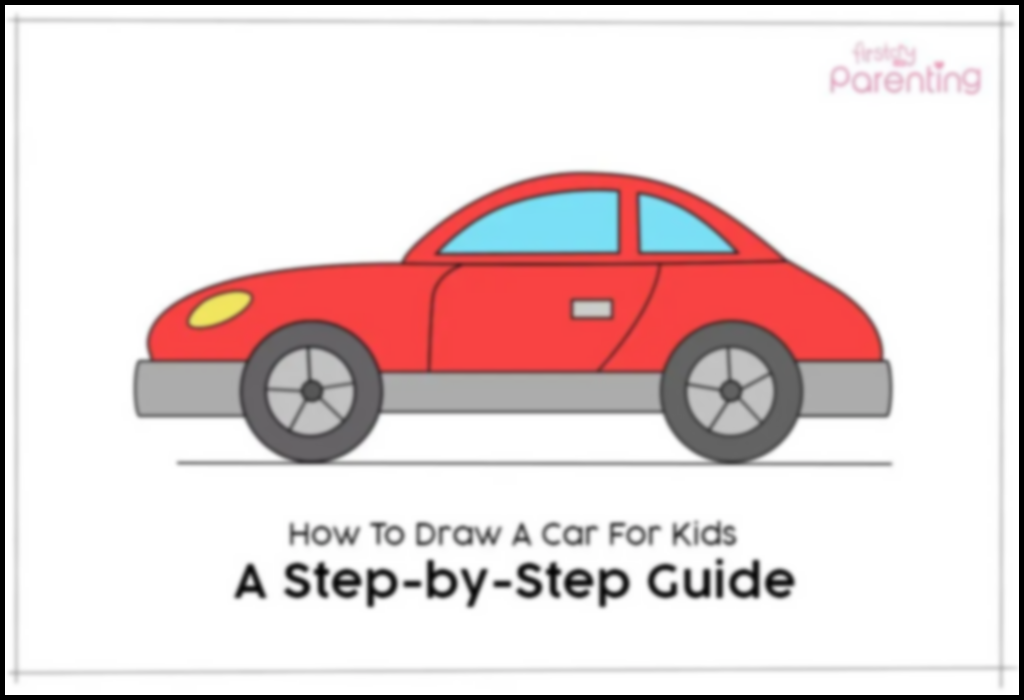

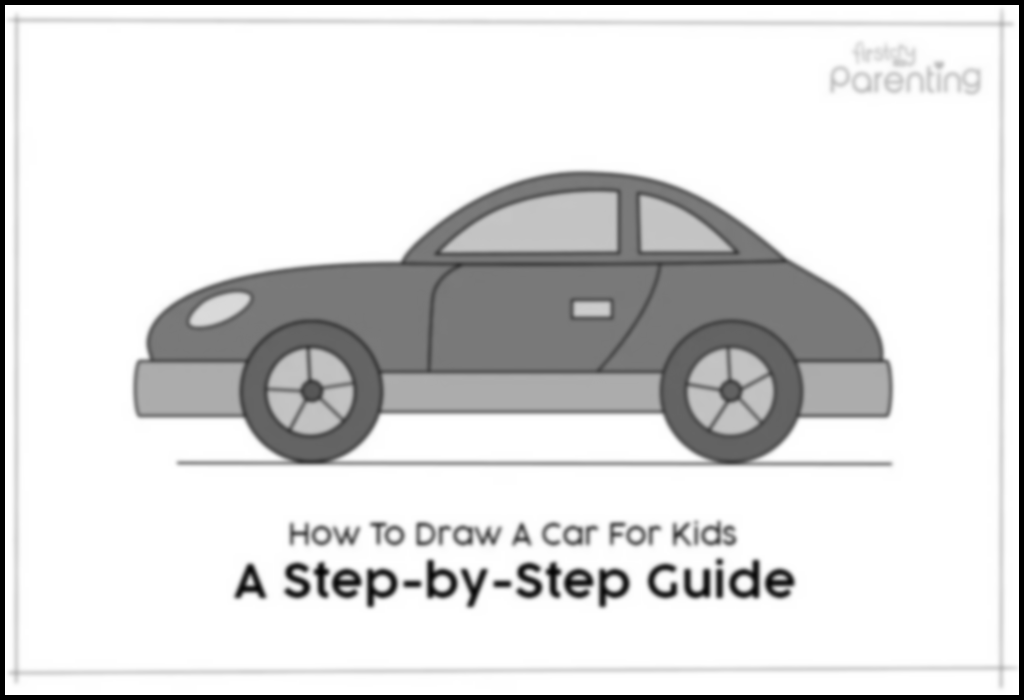

In [ ]:
blured_img = coloredImageGaussianBlur(img,(11,11))
print(blured_img.shape)
cv2_imshow(blured_img)

gray_blureed_img = cv2.cvtColor(blured_img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_blureed_img)

# Assignment 1.2  

*   Using your gaussian filter as a step
*   Implement the canny edge detection algorithm (blur + sobel filter) from scratch
*   Enclose your algorithm in the same function as cv2.Canny()
*   Test the algorithm on a sample image and compare it to openCV counterpart

Resources of code [Wikipedia_Canny_edge_detector](https://en.wikipedia.org/wiki/Canny_edge_detector) & [OpenCV Canny](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de)

Here's the google style i followed here in writing comments [Google Style](https://developers.google.com/style/api-reference-comments)

## Process:-
Process
The process of Canny edge detection algorithm can be broken down to five different steps:


*   Apply Gaussian filter to smooth the image in order to remove the noise
*   Find the intensity gradients of the image
*   Apply gradient magnitude thresholding or lower bound cut-off suppression to get rid of spurious response to edge detection

*   Apply double threshold to determine potential edges
*   Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.

In [ ]:
def convolve(img, kernel):

  """
  Convolves a gray image with a kernel.

    Args:
        img: A numpy array representing the colored image.
        kernel: A numpy array representing the kernel.

    Returns:
        numpy.ndarray: A numpy array representing the convolved image.

    Raises
        ValueError: If kernel dimentions is not a tuple of two positive odd integers.

    Time Complexity:
        O(f(X*Y*Kx*Ky)), where X, Y are the dimentions of the input image
                         Kx, Ky are the dimentions of the kernel.
    """

  kx, ky = kernel.shape

  # Validating kernel dimensions
  if(kx%2 == 0 or ky%2 == 0 or kx == 0 or ky == 0):
    raise Exception(f"Kernel width and height should be odd and positive")

  # Output image
  convolved_img = np.zeros_like(img)

  # Distance to kernel center
  kx = kx//2
  ky = ky//2

  x, y = img.shape[0:2]

  for i in range(kx, x - kx):
    for j in range(ky, y- ky):

      # Slicing the neiborhood of the pixel
      temp = img[i-kx: i+kx+1 , j-ky : j+ky+1]
      convolved_img[i,j] = np.sum(temp*kernel)

  return convolved_img

def sobel(img, lower_threshold, higher_threshold):
  """
  Appplying sobel to Detect image edges.

    Args:
        img: A numpy array representing the colored image.
        lower_threshold: The lower threshold value for edge detection.
        higher_threshold: The higher threshold value for edge detection.

    Returns:
        numpy.ndarray: A numpy array representing an image of edges.

    """

  # Gradient kernel in x and y direction
  gx = np.array([[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]])

  gy = np.array([[-1, -2, -1],
                 [0, 0, 0],
                 [1, 2, 1]])

  gradient_x = convolve(img, gx)
  gradient_y = convolve(img, gy)

  magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
  direction = np.arctan2(gradient_y, gradient_x)

  output_img = np.zeros_like(img)

  # Perform non-maximum suppression
  for i in range(1, img.shape[0] - 1):
      for j in range(1, img.shape[1] - 1):
          # Adding pi if angle is negative Since gradient in any direction can be negative
          if direction[i, j] < 0:
              direction[i, j] += np.pi

          # Compute the indices of the neighboring pixels in the direction of the gradient
          q = np.array([int(np.round(j + np.cos(direction[i, j]) * pos)) for pos in [-1, 0, 1]])
          r = np.array([int(np.round(i - np.sin(direction[i, j]) * pos)) for pos in [-1, 0, 1]])

          # Check if the current pixel is the local maximum in the direction of the gradient
          if magnitude[i, j] >= magnitude[r, q].max():
              # values are too low so trying magnify them with value 10
              output_img[i, j] = magnitude[i, j]*10

  #values, counts = np.unique(output_img, return_counts=True)
  #for value, count in zip(values, counts):
  #    print(f"output {value}: {count}")


  strong_edge_pixels = (output_img > higher_threshold).astype(np.uint8)*255
  weak_edge_pixels = ((output_img >= lower_threshold) & (output_img <= higher_threshold)).astype(np.uint8)


  # Connect weak edges to strong edges
  _, connected_edges = cv2.connectedComponents(strong_edge_pixels)

  # Look up table to all eight neighboor pixels
  dx = [-1, 0, 1, -1, 1, -1, 0, 1]
  dy = [-1, -1, -1, 0, 0, 1, 1, 1]

  # Checking every weak pixel wether it's noise or edge
  for i in range(1, img.shape[0] - 1):
      for j in range(1, img.shape[1] - 1):
          if weak_edge_pixels[i, j] != 0 and connected_edges[i, j] != 0:
              for a,b in zip(dx,dy):
                if strong_edge_pixels[i + a, j + b]:
                  strong_edge_pixels[i, j] = 255
                  break

  output_img = strong_edge_pixels
  return output_img

def canny(img, lower_threshold, higher_threshold):
    """
    Apply the Canny edge detection algorithm to the input image.

    Parameters:
      img: The input image.
      lower_threshold: The lower threshold value for edge detection.
      higher_threshold: The higher threshold value for edge detection.

    Returns:
      numpy.ndarray: The edge image after applying the Canny algorithm.
    """
    # Apply Gaussian blur to the input image
    blured_img = coloredImageGaussianBlur(img, (7, 7))

    # Convert the blurred image to grayscale
    gray_blurred_img = cv2.cvtColor(blured_img, cv2.COLOR_BGR2GRAY)

    # Applying Sobel to detect edges
    output = sobel(gray_blurred_img, lower_threshold, higher_threshold)

    return output

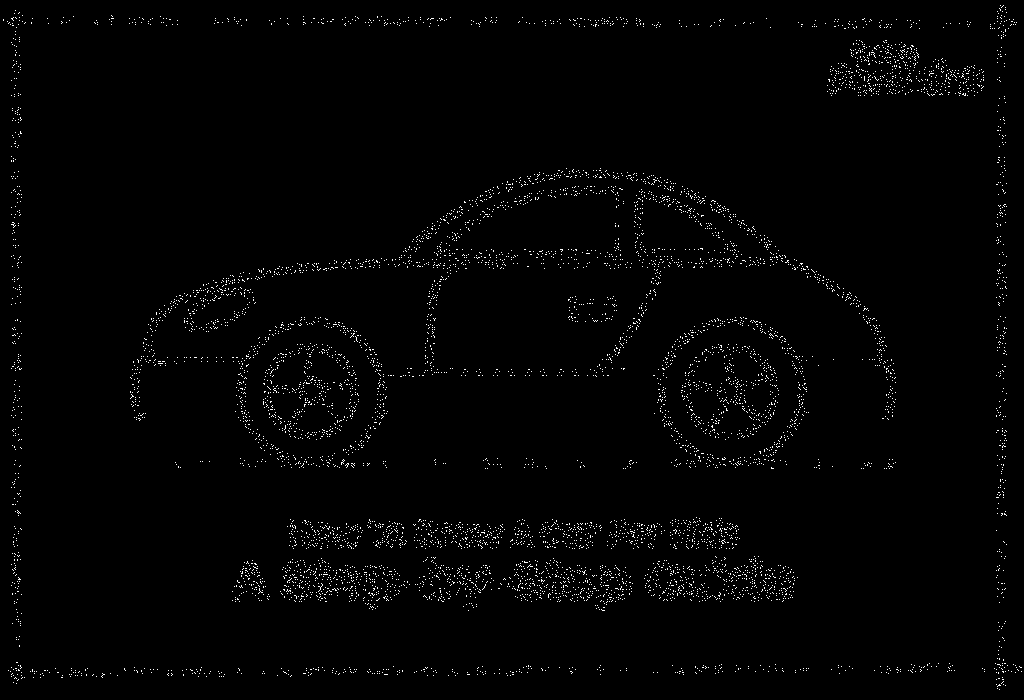

In [ ]:
output = canny(img, 120, 145)
cv2_imshow(output)

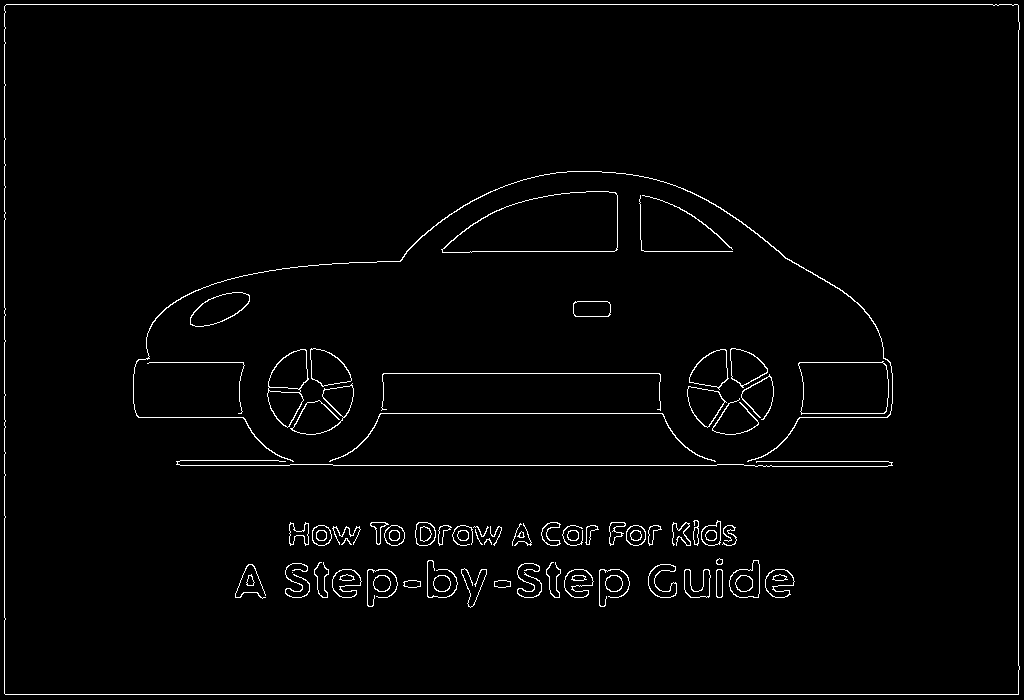

In [ ]:
edges  = cv2.Canny(image=gray_blureed_img, threshold1=100, threshold2=200)
cv2_imshow(edges)

# Assignment 1.3  

*   Implement Histogram Equalization From scratch on distorted license plate image
image-1 and image-2
*   Implement the basic thresholding & morphology operations to make the license
plate numbers & letters more clear image-3

Resources of code [Histogram_equalization](https://en.wikipedia.org/wiki/Histogram_equalization) & [OpenCV threshold](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57) & [Erosion](https://en.wikipedia.org/wiki/Erosion_(morphology)) & [Dilation](https://en.wikipedia.org/wiki/Dilation_(morphology))

Resources of images [Plates images](https://drive.google.com/drive/folders/1xukVffh53_LNxuN4hyXtZfvLMJparMOa)

Here's the google style i followed here in writing comments [Google Style](https://developers.google.com/style/api-reference-comments)

In [ ]:
img1= cv2.imread('image-1.png')
img2= cv2.imread('image-2.png')
img3= cv2.imread('image-3.jpeg')

In [ ]:
def histogram_equalization(img):
    """
    Perform histogram equalization on an image(Gray or colored).

    Args:
        img: The input image.

    Returns:
        numpy.ndarray: The equalized image.
    """

    # Getting dimensions of the image
    x, y = img.shape[0:2]

    # Calculate the count of gray levels
    gray_level = np.zeros(256)
    for i in range(0, x):
        for j in range(0, y):
            gray_level[img[i, j]] += 1

    # Normalizing the histogram
    gray_level /= np.sum(gray_level)

    # Calculate the cumulative distribution function (CDF)
    cdf = np.zeros(256)
    cdf[0] = gray_level[0]
    for i in range(1, 256):
        cdf[i] = gray_level[i] + cdf[i - 1]

    # Scaling the CDF to the range [0, 255]
    cdf *= 255

    equalized_image = np.zeros_like(img)

    # Map each pixel value in the input image to its corresponding equalized value
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            equalized_image[i, j] = cdf[img[i, j]]

    return equalized_image

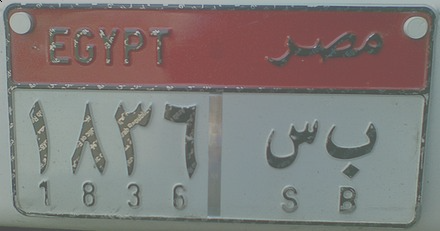

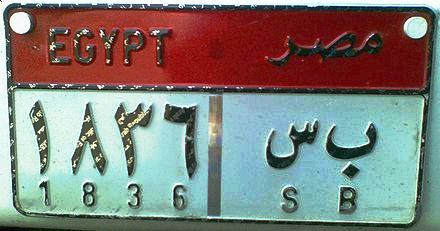

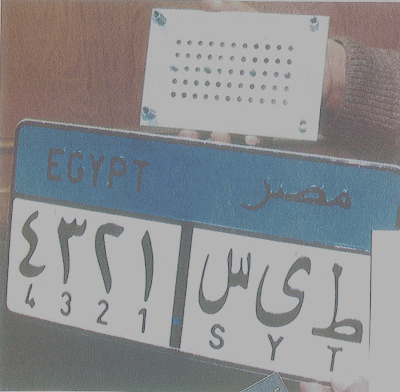

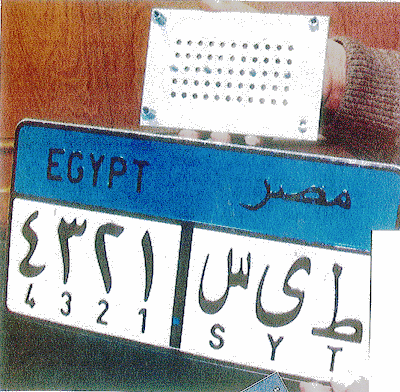

In [ ]:
cv2_imshow(img1)
equalized_image = histogram_equalization(img1)
cv2_imshow(equalized_image)

cv2_imshow(img2)
equalized_image = histogram_equalization(img2)
cv2_imshow(equalized_image)

In [ ]:
def thresholdImg(img, threshold=130, maxval = 'THRESH_BINARY'):
    """
    Convert an image to binary image using a threshold value.

    Args:
        img : The input grayscale image.
        threshold: The threshold value for binarization (default: 130).
        maxval: 'THRESH_BINARY'(Default) values greater than threshold are taken
                'THRESH_BINARY_INV'      values smaller than threshold are taken

    Returns:
        numpy.ndarray: The binary image.

    """

    # Getting dimensions of the image
    x, y = img.shape

    # Create a binary mask based on the threshold and maxval
    if maxval == 'THRESH_BINARY':
      mask = img > threshold
    elif maxval == 'THRESH_BINARY_INV':
      mask = img < threshold

    # Apply the mask to the image
    output = np.zeros_like(img)

    # Set masked pixels to the maximum value (white)
    output[mask] = 255

    return output

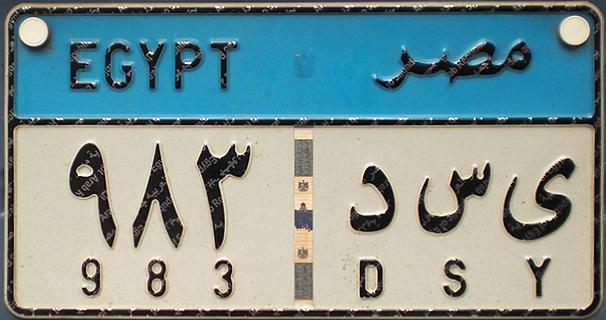

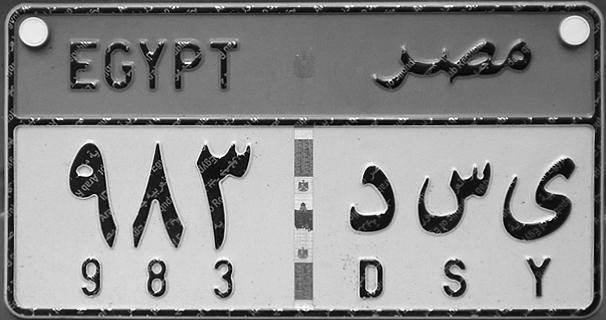

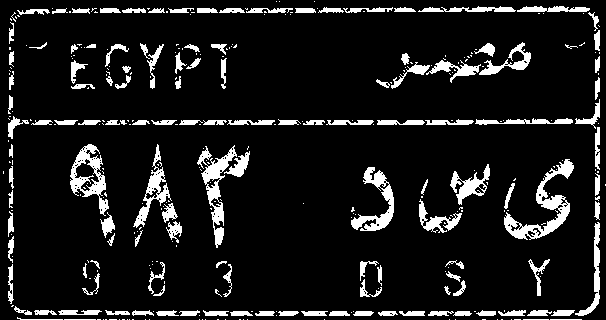

In [ ]:
cv2_imshow(img3)

gray_img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_img3)

threshhold_image = thresholdImg(gray_img3,40,'THRESH_BINARY_INV')
cv2_imshow(threshhold_image)

In [ ]:
def dilation(img,kernel):
    """
    Perform dilation operation on a binary image using a structuring element (kernel).

    Args:
        image: The input binary image.
        kernel: The structuring element for dilation.

    Returns:
        numpy.ndarray: The dilated image.

    """


    # Get the dimensions of the image and kernel
    x, y = img.shape
    kx, ky = kernel.shape

    # Distance to kernel center
    kx //= 2
    ky //= 2

    # Create an empty output array
    dilated_image = np.zeros_like(img)

    # Creating mask
    mask = img==255

    for i in range(kx, x-kx):
        for j in range(ky, y-ky):

            # Extract the neighborhood of the current pixel
            neighborhood = mask[(i-kx):(i+kx+1), (j-ky):(j+ky+1)]

            # Check if the neighborhood matches the kernel
            if any(neighborhood[kernel == 1] == kernel[kernel == 1]):
                dilated_image[i, j] = 255

    return dilated_image

def erosion(img,kernel):
    """
    Perform erosion operation on a binary image using a structuring element (kernel).

    Args:
        image: The input binary image.
        kernel: The structuring element for erosion.

    Returns:
        numpy.ndarray: The eroded image.

    """


    # Get the dimensions of the image and kernel
    x, y = img.shape
    kx, ky = kernel.shape

    # Distance to kernel center
    kx //= 2
    ky //= 2

    # Create an empty output array
    eroded_image = np.zeros_like(img)

    # Creating mask
    mask = img==255

    for i in range(kx, x-kx):
        for j in range(ky, y-ky):

            # Extract the neighborhood of the current pixel
            neighborhood = mask[(i-kx):(i+kx+1), (j-ky):(j+ky+1)]

            # Check if the neighborhood matches the kernel
            if all(neighborhood[kernel == 1] == kernel[kernel == 1]):
                eroded_image[i, j] = 255

    return eroded_image

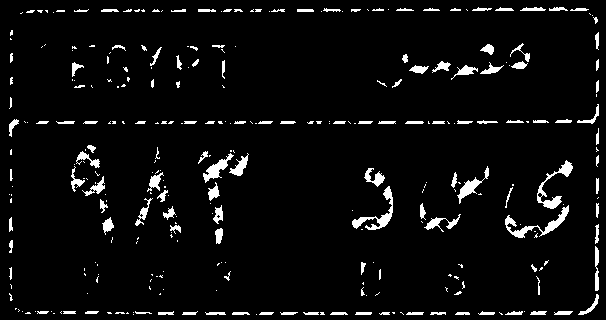

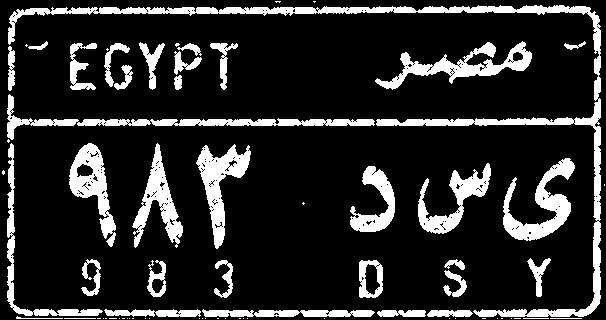

In [ ]:
kernel = np.array([[0, 1, 0],
                   [1, 1, 1],
                   [0, 1, 0]])
eroded_img = erosion(threshhold_image, kernel)
cv2_imshow(eroded_img)

eroded_img = dilation(threshhold_image, kernel)
cv2_imshow(eroded_img)

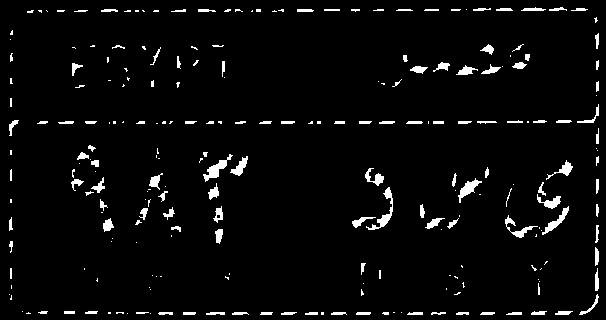

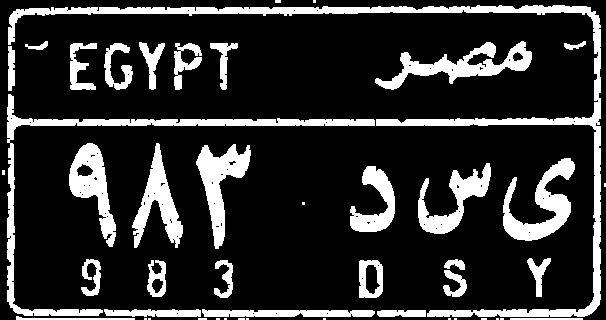

In [ ]:
kernel = np.ones((3,3),np.uint8)

eroded_img = cv2.erode(threshhold_image , kernel , iterations = 1)
cv2_imshow(eroded_img)

dilate_img = cv2.dilate(threshhold_image , kernel , iterations = 1)
cv2_imshow(dilate_img)

**Dilate** made plates information more clearly

Both implemented function and built in functions here are the same.